Taken from https://emcee.readthedocs.io/en/stable/tutorials/quickstart/ (multi-dimensional Gaussian) and https://emcee.readthedocs.io/en/stable/tutorials/line (fitting a model to data)

# How to sample a multi-dimensional Gaussian

In [1]:
import numpy as np

In [5]:
def log_prob(x, mu, cov):
    diff = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

In [32]:
ndim = 5

np.random.seed(42)
means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim ** 2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov, cov)

In [33]:
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

In [34]:
import emcee 

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

In [40]:
state = sampler.run_mcmc(p0, 100) #sample from log_prob(p0) for 100 iterations and return result
sampler.reset() #reset everything

In [49]:
#now do a run of 10000 steps
sampler.run_mcmc(state, 10000) #will pick up from output of state

State([[-0.43424014  1.78803091  0.75224634  0.65915817  0.4734423 ]
 [-0.71238895  0.73426195  1.61712787  0.01255936 -0.88053699]
 [-0.12594128  1.35599541  1.45238318  0.67980103  0.04012247]
 [ 0.61314205  0.05575063  0.08529774  0.33867444 -0.50362248]
 [-0.43664707  0.80436207  1.13204378  0.09380783 -0.86993763]
 [ 0.46853993  0.33075848  1.3573585   0.6343816  -0.06090445]
 [ 1.33160321  0.85641285  0.24891645  0.60504798  0.31227906]
 [-0.01892609 -0.69794138  0.75504743  0.57176373 -0.56125437]
 [ 0.10126089  0.83103772  0.41637254  1.19650469  0.94380252]
 [ 0.77011537  1.04838809  0.34784618  0.23919228 -0.68069185]
 [ 0.34249082  1.74170469  0.2715152   0.44037013  0.33070086]
 [ 0.63990461  0.20794172  0.55347742  0.50262532  0.59795591]
 [-0.61191978  0.87287941  0.72937147  0.46822771 -0.10662417]
 [ 1.3868385   1.24258573  0.42448945  0.96352562  0.7483911 ]
 [ 0.23483736  0.92491094  0.7886009   0.5403674  -0.20953847]
 [ 0.79224679  2.26723672  0.59926754  0.05649208

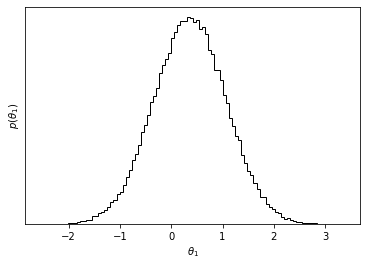

In [52]:
import matplotlib.pyplot as plt

samples = sampler.get_chain(flat=True) #get results of last mcmc run and flatten it
plt.hist(samples[:, 0], 100, color='k', histtype='step')
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]) #only place y-ticks
plt.show()

In [55]:
print('Mean acceptance fraction: {0:.3f}'.format(
        np.mean(sampler.acceptance_fraction)))

print('Mean autocorrelation time: {0:.3f} steps'.format(
        np.mean(sampler.get_autocorr_time())))

Mean acceptance fraction: 0.552
Mean autocorrelation time: 57.112 steps


# Fitting a model to data

In [56]:
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

### The generative probabilistic model

In [57]:
import numpy as np
import matplotlib.pyplot as plt

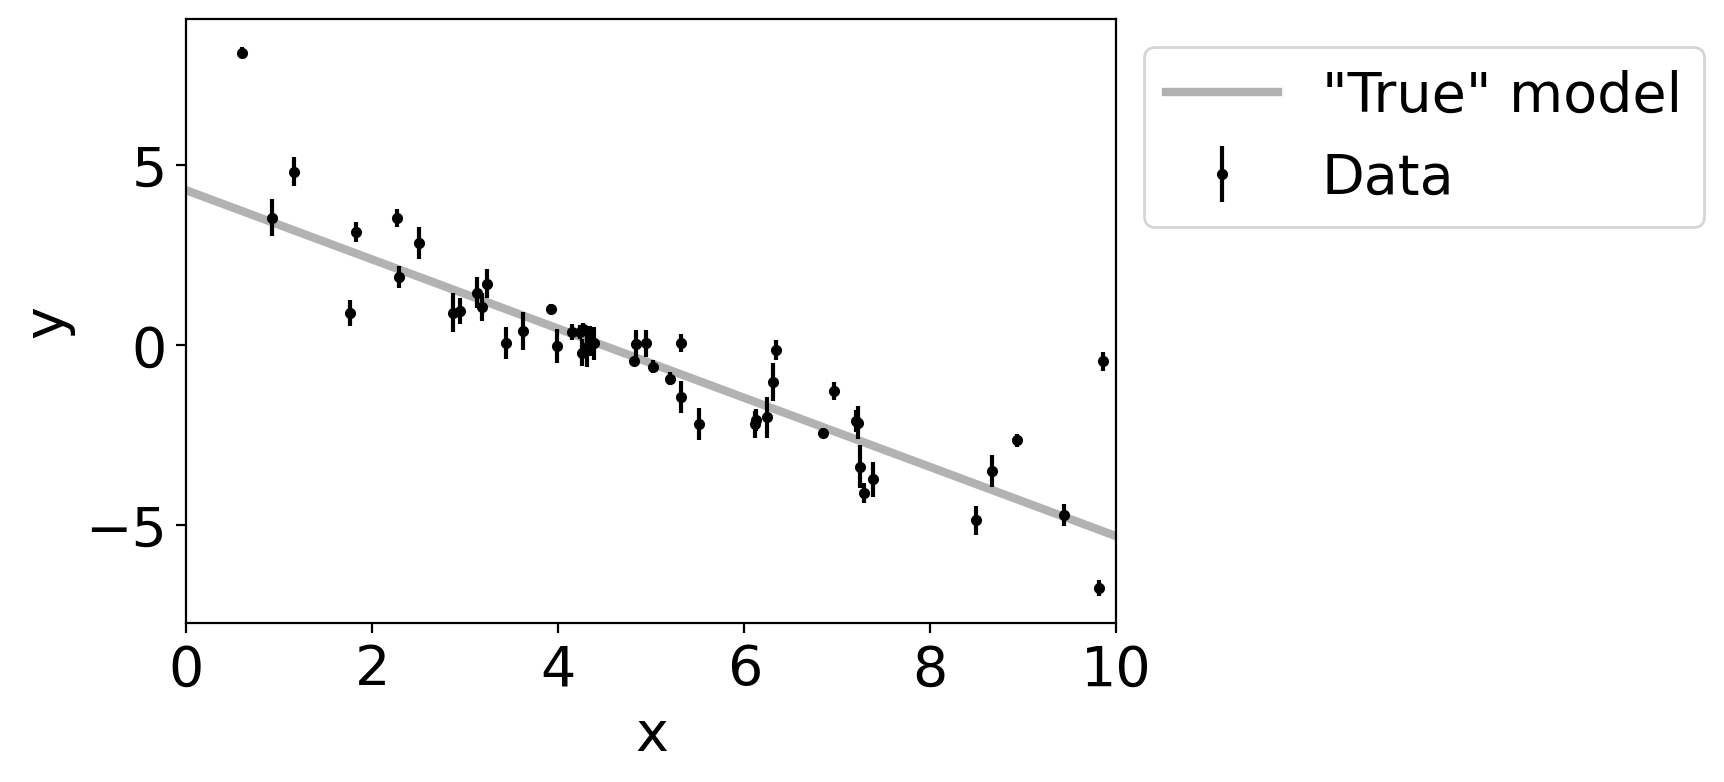

In [71]:
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594 ## slope
b_true = 4.294 ## y-int
f_true = 0.534 ## constant fractional amount

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N)) ## sort the randomized data
yerr = 0.1 + 0.5 * np.random.rand(N) ## create associated error on measurements
y = m_true * x + b_true ## true best fit
y += np.abs(f_true * y) * np.random.randn(N) ## offset each x measurement by f_true
y += yerr * np.random.randn(N) ## add the error to each x measurement

plt.figure()
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label='Data')
x0 = np.linspace(0, 10, 500) ## plotting over x range
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label='"True" model')
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

The effect of the underestimated uncertainties is obvious when you look at this figure. The line seems to fit the data well but is not captured by the errorbars, which is an issue.

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


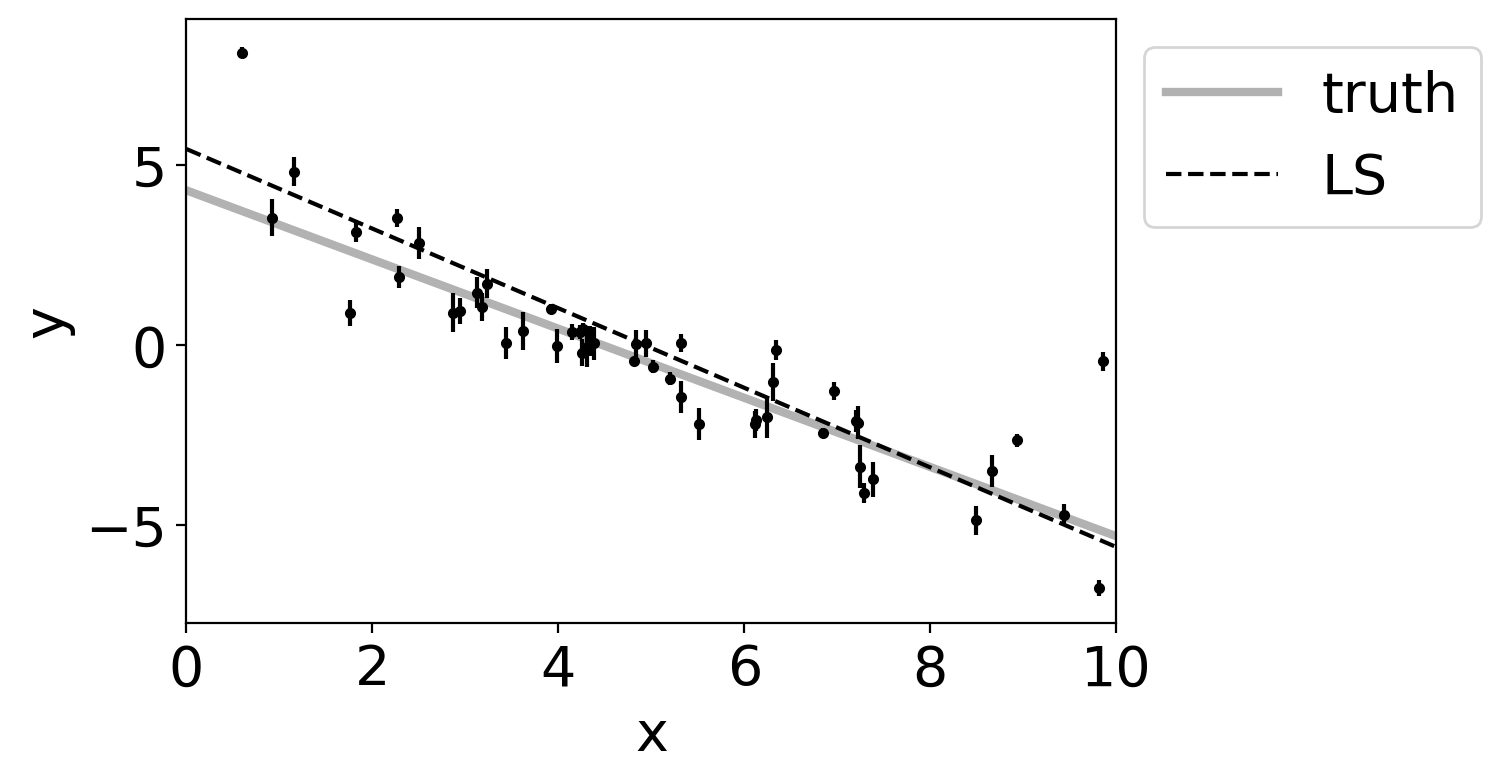

In [78]:
## Performing least-squares analysis (LS)

A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.figure()
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0) ## plot the data
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth") ## plot "true" model from before
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS") ## plot LS results
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

LS model isn't unreasonable. However, the errors on the LS estimates seem excessively small. This is an artifact of our underestimation of the errors in the first place. The solutions given here are the maximum likelihood result for a model in which the errors are assumed to be correct, Gaussian, and independent. But this might not always be the case.

### Maximum likelihood estimation

In [80]:
## New likelihood function

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))


Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


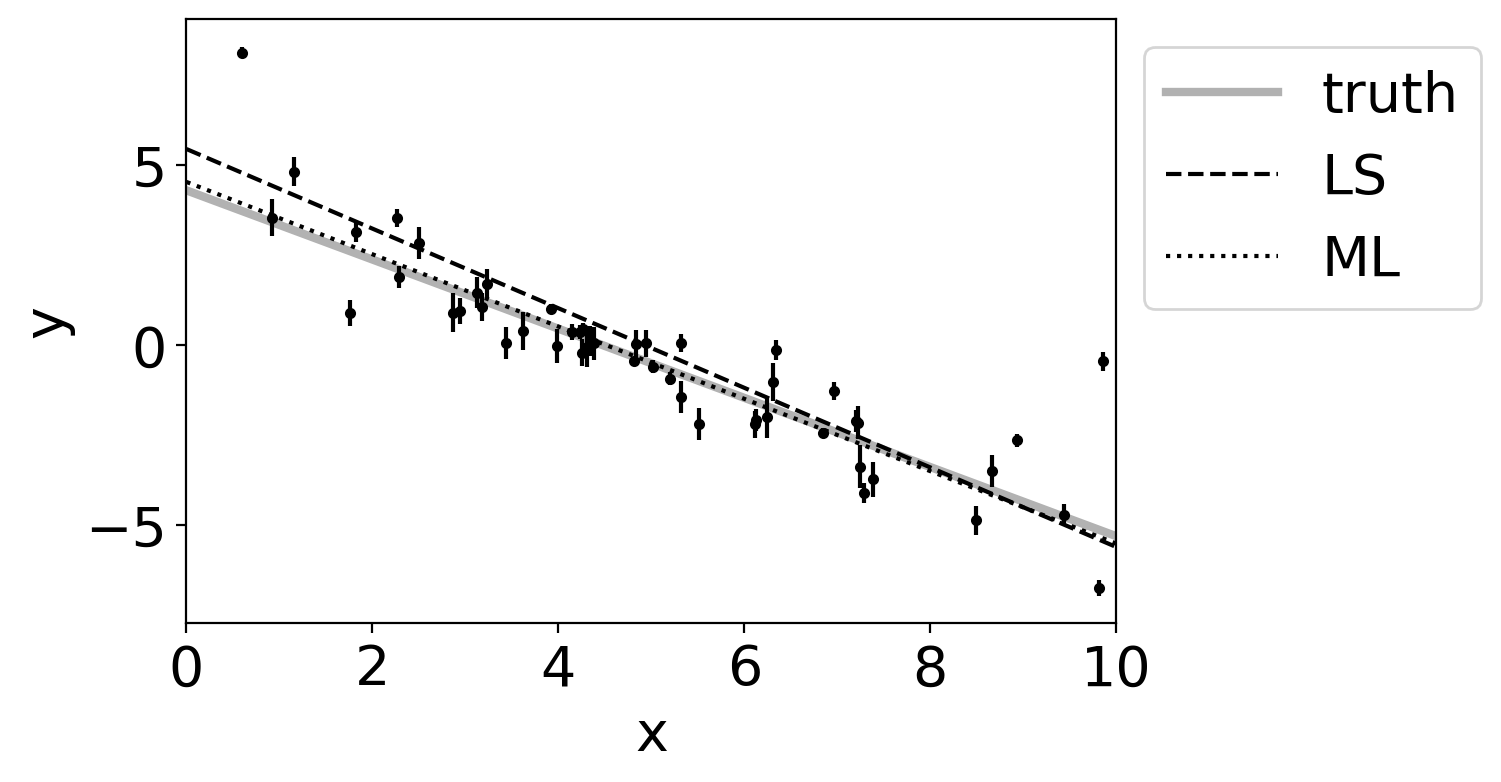

In [93]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
# maximizing the likelihood is the same as minimizing the negative of the liklihood
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr)) 
# maximizing the likelihood is the same as minimizing the negative of the liklihood
m_ml, b_ml, log_f_ml = soln.x
## very similar to LS method, with exception of likelihood function being different

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.figure()
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0) ## plot the data
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth") ## plot the "true" model
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS") ## plot the LS model
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML") ## plot the max likelihood model
## Use of np.vander() is confusing to me
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

ML is much closer to "true" than LS was. But what is the error associated with these values?

### Marginalization and uncertainty estimation

Look up:
   - posterior probability function

In [95]:
## expectations of range ("priors") of m, b, and f

def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        ## sets up priors (expectations) on m, b and log(f)
        return 0.0
    return -np.inf

In [97]:
## Full log-probability function

## A little confusing

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta) ## Call previous function
    if not np.isfinite(lp): ## if lp is -inf, return -inf 
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr) #otherwise

In [111]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 666.43it/s]


<IPython.core.display.Javascript object>


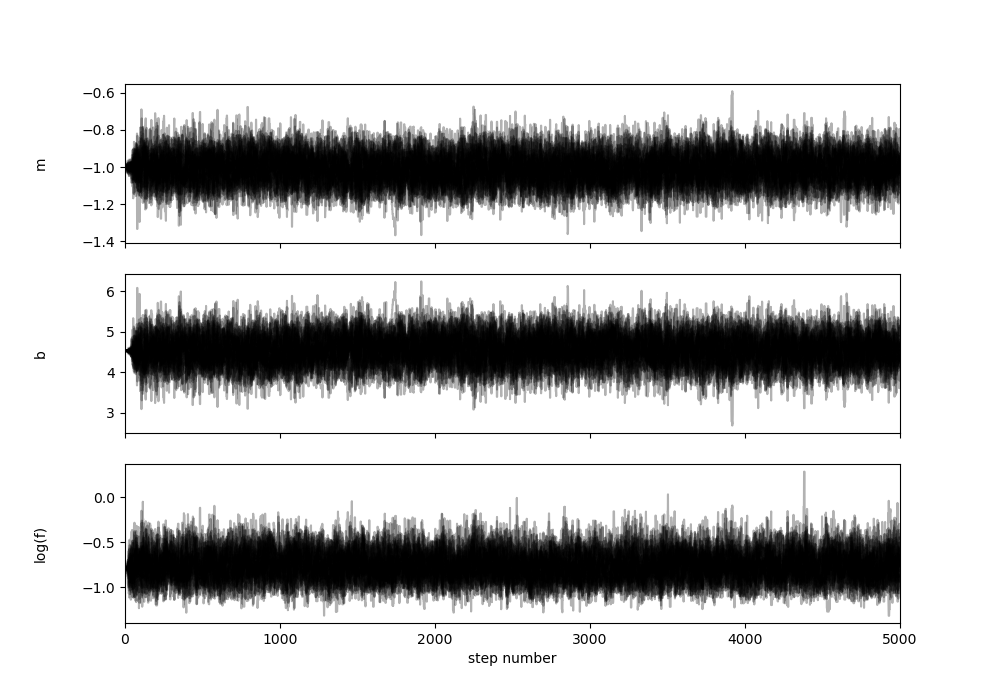

In [125]:
# %matplotlib notebook 
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [116]:
## Integrated autocorrelation time

## Confused on how they are using autocorrelation here/what is autocorrelation time?
## From arXiv:1011.0175v1: Conceptually, the autocorrelation time is the number of Markov chain transitions equivalent to a single independent draw from the distribution of {Xi}.

tau = sampler.get_autocorr_time()
print(tau)

[39.8771245  40.03077031 40.59879627]


Suggests it took only about 40/5000 steps for the chain to "forget" where it started (move away and explore the larger parameter space).

In [115]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
## discard the initial 100 steps
## thin chain by 15 (approx half of AC time)
## flatten chain
print(flat_samples.shape)

(10432, 3)


### Results

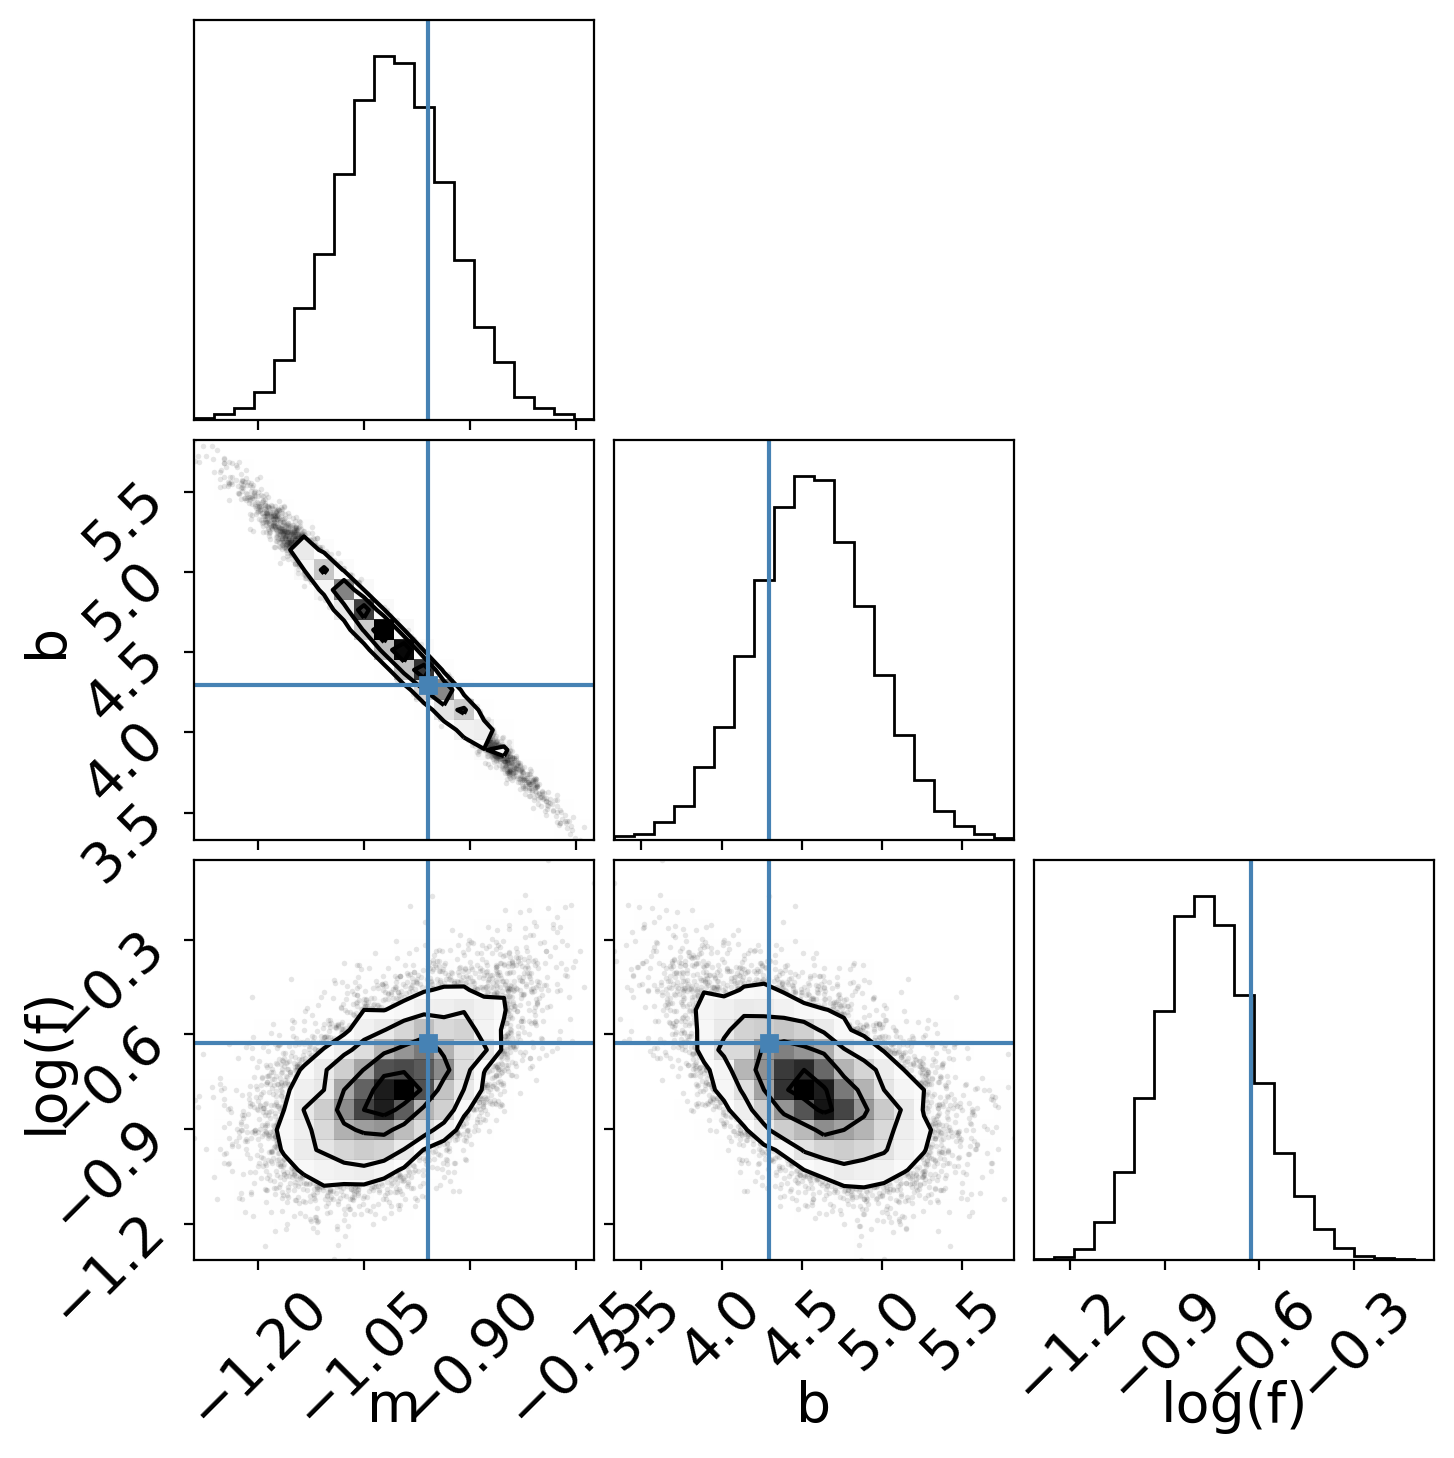

In [123]:
import corner

fig = corner.corner(
    flat_samples,
    labels=labels,
    truths=[m_true, b_true, np.log(f_true)]);

This is a projection plot of the posterior probability distribution as a function of the three variables.

Need help: 
   - Understanding/fully interpretting the corner plot
   - Why is there an offset from peaks of curves/points of highest density?
   - Each of these params are considered calculated to 2-sigma, right?
   